In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [ ]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )

    #count missing values in X
    missing_values_count = X.isnull().sum().sum()
    print(f"Missing values in X: {missing_values_count}")

    X = np.array(X)
    y = np.array(y)[..., None]
    print(X.shape)
    print(y.shape)
    
    # Determine if the dataset has categorical features
    has_categorical = any(categorical_indicator)
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
        'has_categorical': has_categorical,
        'n_missing_values': missing_values_count,
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
df_metadata.sort_values('%_unique_y', ascending=True)

# Display the metadata DataFrame
df_metadata.loc[44962, "has_categorical"] = True
df_metadata

In [ ]:
from optuna_kfoldCV import np_load_openml_dataset, openML_reg_ids
import numpy as np

for idx, id in enumerate(openML_reg_ids):
    X,y = np_load_openml_dataset(id, "regression")
    print("idx", idx, "id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# for id in df_metadata.index:
#     X,y = np_load_openml_dataset(id, "regression")
#     print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())


## TODO TODO TODO NEXT: investigate nans, and "Mean of empty slice". also look at less than 200 features and check performance on reg

# Run experiments (just for testing)

In [4]:
# !python regression_param_specs.py \
#     --models End2End \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models Ridge \
#     --dataset_indices 10 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models XGBoostRegressor \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GradientRFRBoost_upscaleiid \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [9]:
# !python regression_param_specs.py \
#     --models GradientRFRBoost_upscaleiid \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostDense \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostDiag \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models GreedyRFRBoostScalar \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python regression_param_specs.py \
#     --models RFNN \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

# join json results

In [2]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor",
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_reg_ids,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            #print(path)
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [3]:
models = ["End2End_cpu", 
                "Ridge", 
                "XGBoostRegressor", 
                "RFNN", "RFNN_iid",
                "GreedyRFRBoostDiag", "GreedyRFRBoostScalar"
                ]
for up in ["", "_upscaleiid", "_ID"]:
    for bn in ["", "_batchnormFalse"]:
        models.append(f"GradientRFRBoost{up}{bn}")
        models.append(f"GreedyRFRBoostDense{up}{bn}")

for name in  [#"RFRBoost_upscaleiid", "RFRBoost_upscaleiid_linesearchFalse", 
              #"RFRBoost_upscaleiid_batchnormFalse", "RFRBoost_ID",
              #"RFRBoost_linesearchFalse_batchnormFalse",
              #"RFRBoost_upscaleiid_linesearchFalse_batchnormFalse",
              "End2End_cpu",
              #"XGBoostRegressor",
              ]:
    models.remove(name)


save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/"

In [4]:
models = [
    "End2End_cpu",
    "Ridge",
    "XGBoostRegressor",
    "RFNN",
    "GreedyRFRBoostDiag_batchnormFalse",
    "GreedyRFRBoostScalar_batchnormFalse",
    "GradientRFRBoost_ID_batchnormFalse",
    "GreedyRFRBoostDense_ID_batchnormFalse",
]

In [5]:
for i in range(34):
    for model in models:
        try:
            results = results_to_df(models=[model], datasets=[openML_reg_ids[i]],
                                    save_dir=save_dir)
        except:
            print(f"Failed for {model} on {i}, ie {openML_reg_ids[i]}")
            pass

In [6]:
df = results_to_df(        
    models = models,
    datasets = openML_reg_ids[[i for i in range(len(openML_reg_ids)) if i not in []]],
    save_dir=save_dir,
    )


In [7]:
df["score_test"].mean().sort_values(ascending=True)
# GradientRFRBoost_upscaleiid        0.409032
# End2End                              0.4101
# GreedyRFRBoostDense_upscaleiid     0.411854
# GreedyRFRBoostDiag_upscaleiid       0.43373
# GreedyRFRBoostScalar_upscaleiid    0.456377
# RandomFeatureNetwork_iid           0.494089
# Ridge                              0.529513
# dtype: object

XGBoostRegressor                          0.39544
GradientRFRBoost_ID_batchnormFalse       0.408516
GreedyRFRBoostDense_ID_batchnormFalse     0.40969
End2End_cpu                              0.416709
GreedyRFRBoostDiag_batchnormFalse        0.419362
GreedyRFRBoostScalar_batchnormFalse      0.433412
RFNN                                     0.433768
Ridge                                    0.539519
dtype: object

In [8]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostRegressor                          0.22263
End2End_cpu                              0.292666
GradientRFRBoost_ID_batchnormFalse       0.363002
GreedyRFRBoostDense_ID_batchnormFalse     0.36379
GreedyRFRBoostDiag_batchnormFalse        0.380949
RFNN                                      0.39962
GreedyRFRBoostScalar_batchnormFalse      0.400828
Ridge                                    0.532424
dtype: object

In [9]:
df["score_test"].rank(axis=1).mean().sort_values()
# GradientRFRBoost_upscaleiid        2.400000
# GreedyRFRBoostDense_upscaleiid     2.400000
# End2End                            3.542857
# GreedyRFRBoostDiag_upscaleiid      3.685714
# GreedyRFRBoostScalar_upscaleiid    4.657143
# RandomFeatureNetwork_iid           5.371429
# Ridge                              5.942857
# dtype: float64

GradientRFRBoost_ID_batchnormFalse       2.617647
GreedyRFRBoostDense_ID_batchnormFalse    2.794118
XGBoostRegressor                         3.323529
GreedyRFRBoostDiag_batchnormFalse        4.470588
End2End_cpu                              4.882353
RFNN                                     5.264706
GreedyRFRBoostScalar_batchnormFalse      5.470588
Ridge                                    7.176471
dtype: float64

In [10]:
df["score_test"].rank(axis=1).mean().sort_values()
# GradientRFRBoost_upscaleiid        2.400000
# GreedyRFRBoostDense_upscaleiid     2.400000
# End2End                            3.542857
# GreedyRFRBoostDiag_upscaleiid      3.685714
# GreedyRFRBoostScalar_upscaleiid    4.657143
# RandomFeatureNetwork_iid           5.371429
# Ridge                              5.942857
# dtype: float64




# XGBoostRegressor               2.882353
# GRFRBoostedXGBoostRegressor    3.588235
# GradientRFRBoost               4.147059
# GreedyRFRBoostDense            4.352941
# GreedyRFRBoostDiag             5.441176
# End2End                        5.794118
# RandomFeatureNetwork_iid       5.794118
# RandomFeatureNetwork           6.176471
# GreedyRFRBoostScalar           8.147059
# Ridge                          8.676471
# dtype: float64

GradientRFRBoost_ID_batchnormFalse       2.617647
GreedyRFRBoostDense_ID_batchnormFalse    2.794118
XGBoostRegressor                         3.323529
GreedyRFRBoostDiag_batchnormFalse        4.470588
End2End_cpu                              4.882353
RFNN                                     5.264706
GreedyRFRBoostScalar_batchnormFalse      5.470588
Ridge                                    7.176471
dtype: float64

# Print results

In [11]:
df_renamed = {k:v for k,v in df.items()}
print(df_renamed["score_test"].columns)
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key].rename(columns={
        "End2End_cpu": "E2E MLP ResNet",
        "Ridge": "Ridge Regression",
        "XGBoostRegressor": "XGBoost",
        "RFNN": "RFNN",
        "GreedyRFRBoostScalar_batchnormFalse": "Greedy RFRBoost $\Delta_{scalar}$",
        "GreedyRFRBoostDiag_batchnormFalse": "Greedy RFRBoost $\Delta_{diag}$",
        "GreedyRFRBoostDense_ID_batchnormFalse": "Greedy RFRBoost $\Delta_{dense}$",
        "GradientRFRBoost_ID_batchnormFalse": "Gradient RFRBoost",
        })
print(df_renamed["score_test"].columns)

Index(['End2End_cpu', 'Ridge', 'XGBoostRegressor', 'RFNN',
       'GreedyRFRBoostDiag_batchnormFalse',
       'GreedyRFRBoostScalar_batchnormFalse',
       'GradientRFRBoost_ID_batchnormFalse',
       'GreedyRFRBoostDense_ID_batchnormFalse'],
      dtype='object')
Index(['E2E MLP ResNet', 'Ridge Regression', 'XGBoost', 'RFNN',
       'Greedy RFRBoost $\Delta_{diag}$', 'Greedy RFRBoost $\Delta_{scalar}$',
       'Gradient RFRBoost', 'Greedy RFRBoost $\Delta_{dense}$'],
      dtype='object')


/tmp/ipykernel_79049/3293569583.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


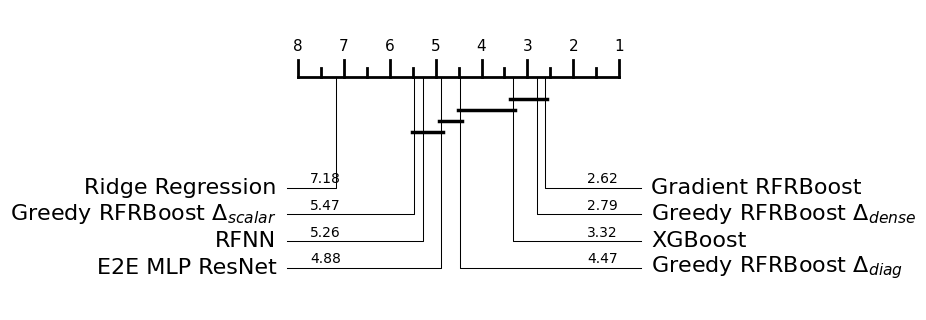

In [13]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df_renamed["score_test"].values,
                                df_renamed["score_test"].columns.tolist(), 
                                alpha=0.05, 
                                lower_better=True,
                                digits=2,
                                width=7, #default 6
                                textspace=2.0, #default 1.5
                                )

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.eps", bbox_inches='tight')
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.png", bbox_inches='tight')

In [13]:
import pandas as pd
import numpy as np

def create_latex_table(
        df_scores: pd.DataFrame, 
        df_t_fit: pd.DataFrame, 
        decimals: int = 3, 
        include_std: bool = False) -> str:
    table = """\\begin{table}[t]
\\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\\label{tab:openml-regression}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & RMSE & Fit Time (s) \\\\
\\midrule
"""
    # Calculate means and stds
    score_means = df_scores.mean()
    score_stds = df_scores.std()
    time_means = df_t_fit.mean()
    time_stds = df_t_fit.std()
    
    # Create sorted index based on scores
    sorted_idx = score_means.sort_values(ascending=True).index
    
    # Create formatted rows
    for model in sorted_idx:
        if include_std:
            score_str = f"{score_means[model]:.{decimals}f} ({score_stds[model]:.{decimals}f})"
            time_str = f"{time_means[model]:.{decimals}f} ({time_stds[model]:.{decimals}f})"
        else:
            score_str = f"{score_means[model]:.{decimals}f}"
            time_str = f"{time_means[model]:.{decimals}f}"
        table += f"{model} & {score_str} & {time_str} \\\\\n"
    
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table


#usage
latex_table = create_latex_table(df_renamed["score_test"], df_renamed["t_fit"])
print(latex_table)

\begin{table}[t]
\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\label{tab:openml-regression}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & RMSE & Fit Time (s) \\
\midrule
XGBoost & 0.395 & 1.873 \\
Gradient RFRBoost & 0.409 & 3.524 \\
Greedy RFRBoost $\Delta_{dense}$ & 0.410 & 3.873 \\
E2E MLP ResNet & 0.417 & 38.909 \\
Greedy RFRBoost $\Delta_{diag}$ & 0.419 & 1.466 \\
Greedy RFRBoost $\Delta_{scalar}$ & 0.433 & 1.405 \\
RFNN & 0.434 & 0.060 \\
Ridge Regression & 0.540 & 0.003 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# Look at distribution of params

Model: GradientRFRBoost_ID_batchnormFalse


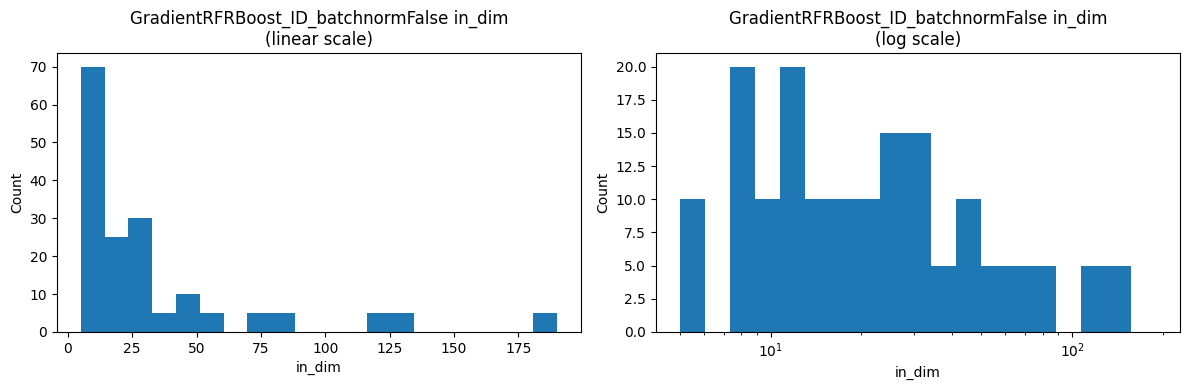

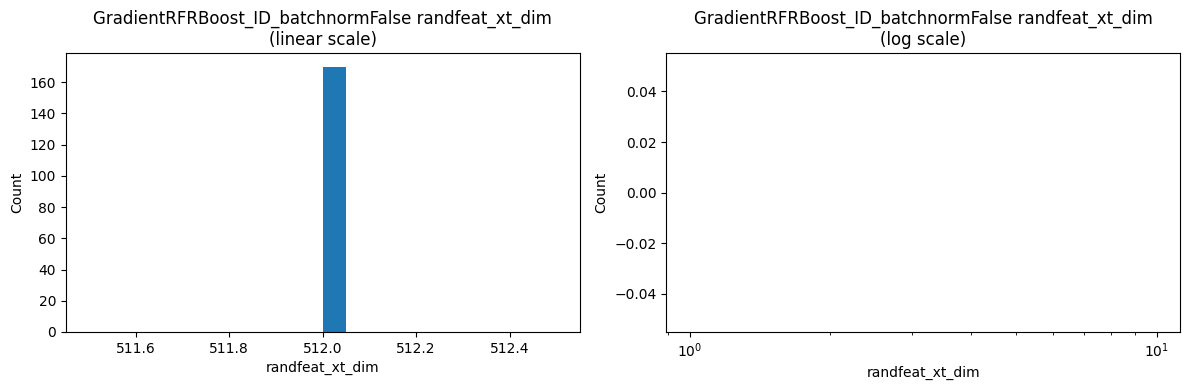

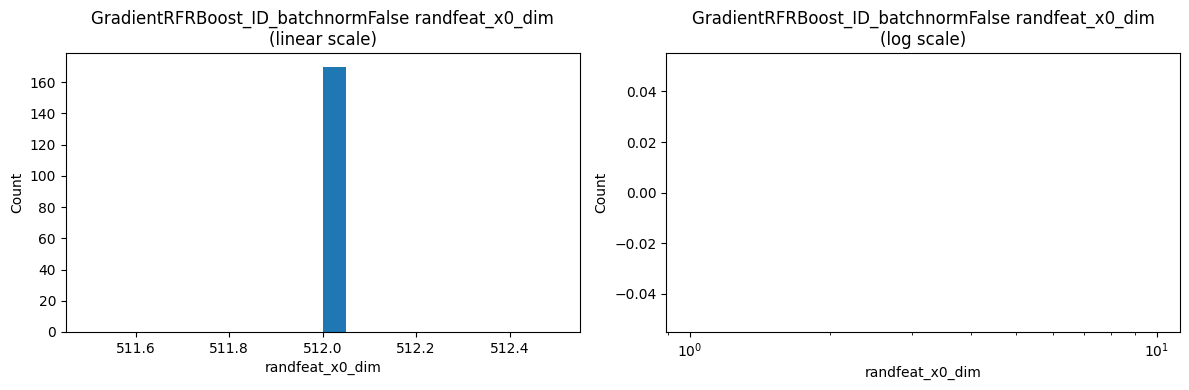

/tmp/ipykernel_79049/4146856767.py:48: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/numpy/core/function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start


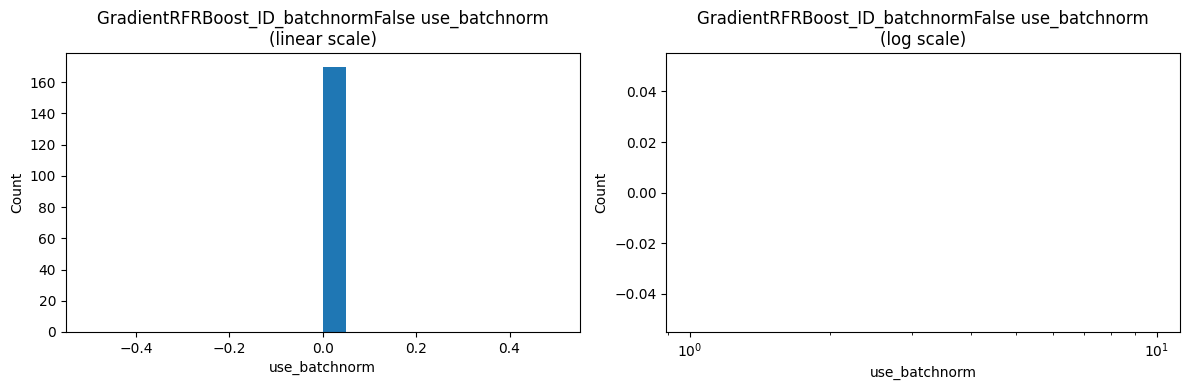

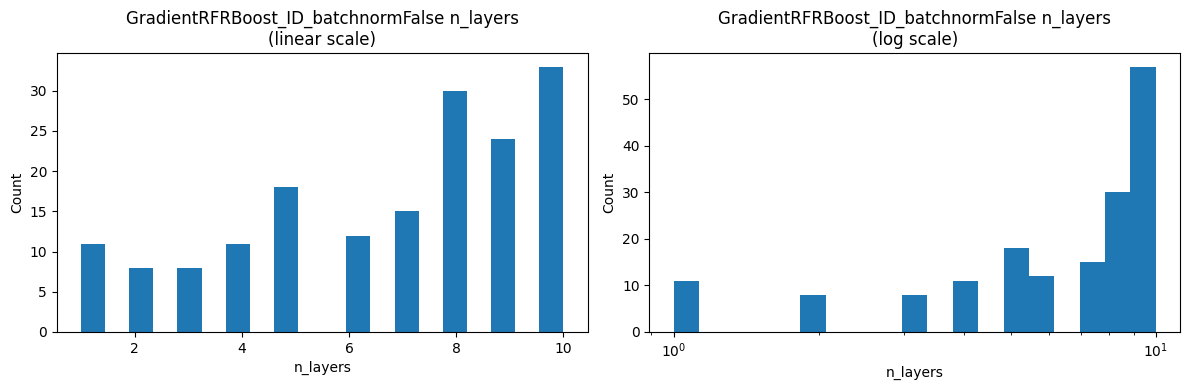

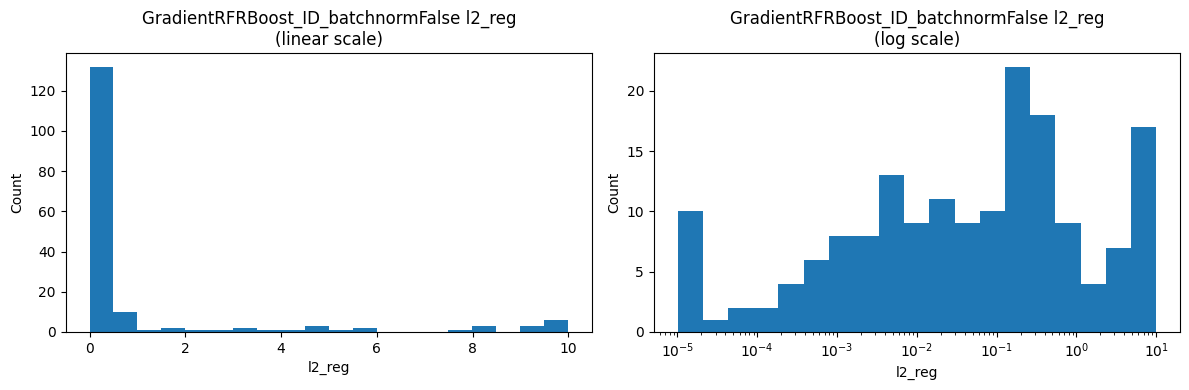

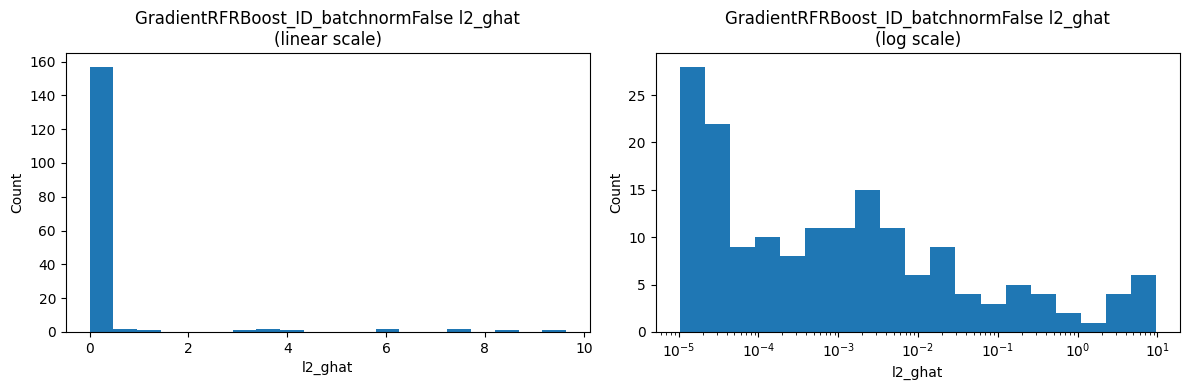

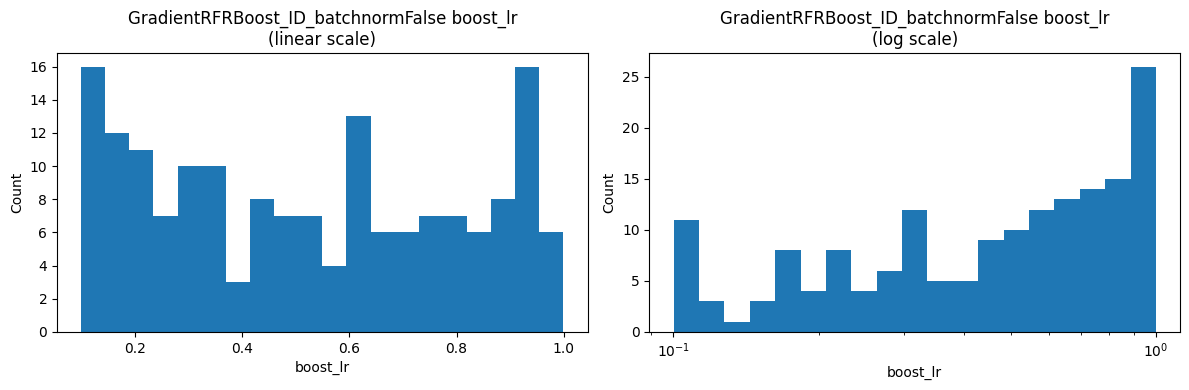

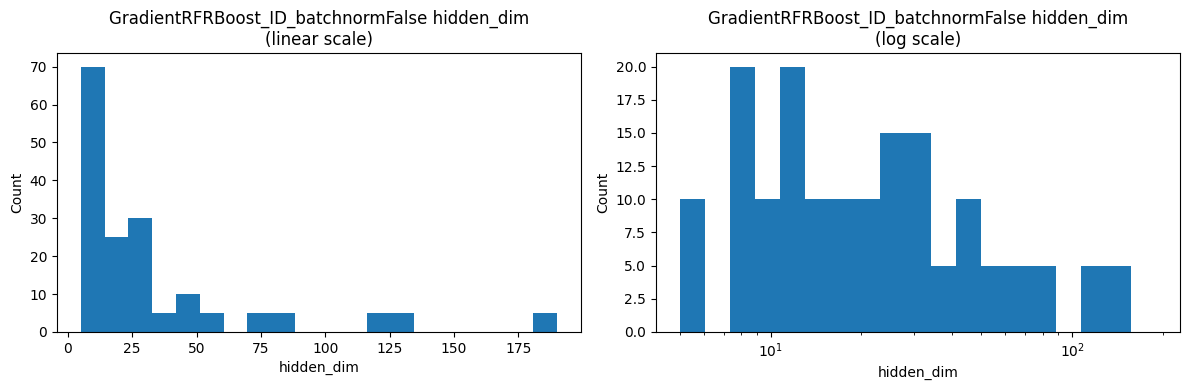

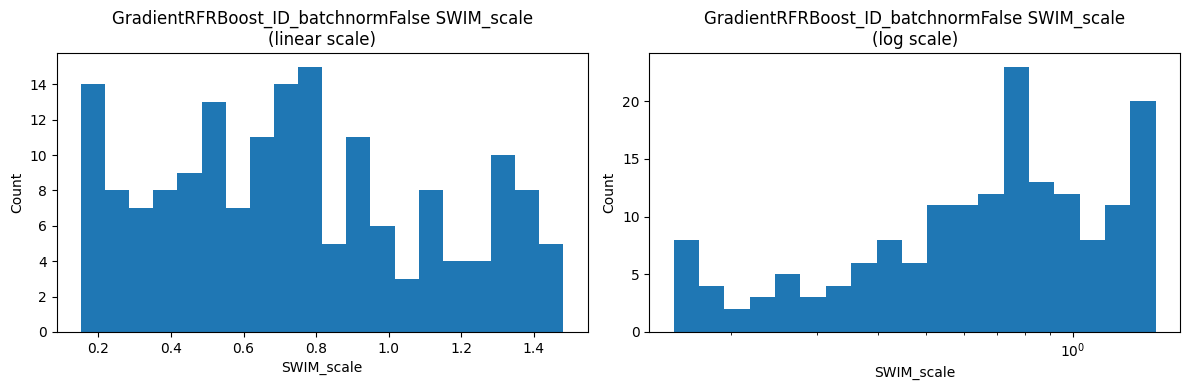

In [19]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = [
                  "GradientRFRBoost_ID_batchnormFalse", 
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale_type", "sandwich_solver", "activation"
                ]:
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()